In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# hyperparameter
height = 224
width = 224
channels = 3
batch_size = 256
img_shape = (height, width, channels)
img_size = (height, width)

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/train',
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/val',
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size
                                                    )

labels = train_ds.class_names
print(labels)

with open('food_label.txt', 'w') as f:
    for food_class in labels:
        f.write(f'{food_class}\n')

Found 20038 files belonging to 54 classes.
Found 5179 files belonging to 54 classes.
['Alpukat', 'Anggur', 'Apel', 'Asparagus', 'Brokoli', 'Buah naga', 'Ceker ayam', 'Dada ayam', 'Durian', 'Jagung', 'Jambu Air', 'Jeruk', 'Kacang Mete', 'Kacang polong', 'Kacang tanah', 'Kangkung', 'Kelapa', 'Kembang Kol', 'Kentang', 'Klengkeng', 'Labu', 'Labu Siam', 'Leci', 'Lemon', 'Lobak Merah', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Nangka', 'Nasi merah', 'Nasi putih', 'Paha bawah ayam', 'Paprika', 'Pare', 'Pepaya', 'Pir', 'Pisang', 'Pokcoy', 'Pork belly', 'Rambutan', 'Salmon', 'Sayap Ayam', 'Semangka', 'Singkong', 'Stroberi', 'Tahu', 'Tauge', 'Telur', 'Tempe', 'Terong', 'Tomat', 'Ubi', 'Wortel']


In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.1)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

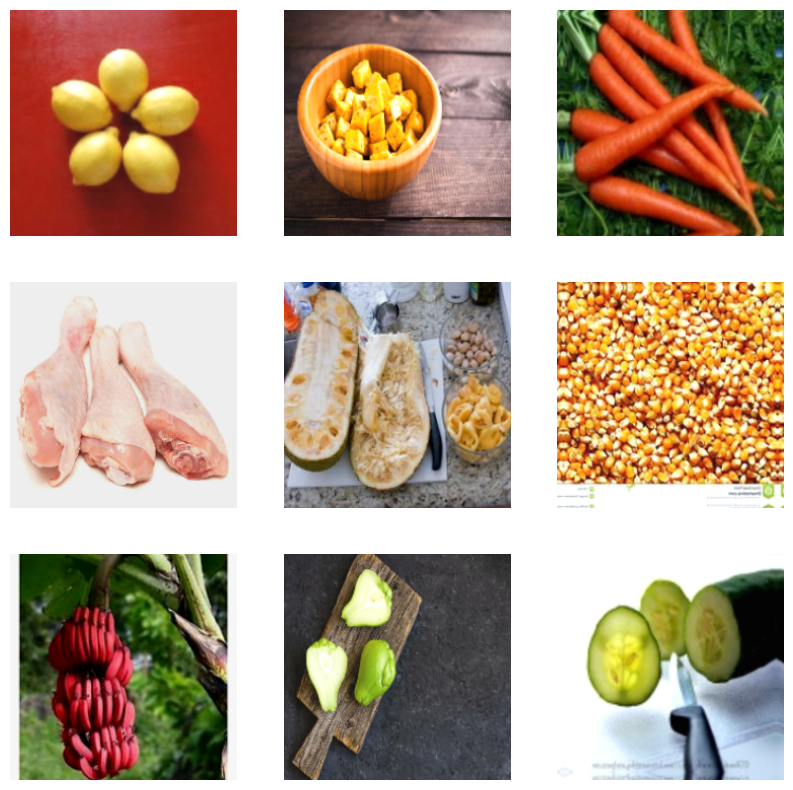

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

In [6]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [7]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

food_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

food_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

food_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = food_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100,
                            callbacks = [early_stopping_callback]
                           )

Epoch 1/100
79/79 [==============================] - 224s 3s/step - loss: 3.4957 - accuracy: 0.1299 - val_loss: 3.7567 - val_accuracy: 0.1027
Epoch 2/100
79/79 [==============================] - 197s 2s/step - loss: 3.2016 - accuracy: 0.1760 - val_loss: 3.3687 - val_accuracy: 0.1261
Epoch 3/100
79/79 [==============================] - 197s 2s/step - loss: 3.0769 - accuracy: 0.2007 - val_loss: 3.2081 - val_accuracy: 0.1657
Epoch 4/100
79/79 [==============================] - 201s 2s/step - loss: 2.9712 - accuracy: 0.2229 - val_loss: 3.1199 - val_accuracy: 0.1809
Epoch 5/100
79/79 [==============================] - 198s 2s/step - loss: 2.9150 - accuracy: 0.2333 - val_loss: 3.0544 - val_accuracy: 0.1904
Epoch 6/100
79/79 [==============================] - 197s 2s/step - loss: 2.8419 - accuracy: 0.2421 - val_loss: 3.0469 - val_accuracy: 0.2035
Epoch 7/100
79/79 [==============================] - 198s 2s/step - loss: 2.7937 - accuracy: 0.2607 - val_loss: 3.0058 - val_accuracy: 0.2107
Epoch 

In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/test',
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size
                                                    )

Found 2574 files belonging to 54 classes.


11/11 [==============================] - 15s 444ms/step - loss: 2.8042 - accuracy: 0.2688


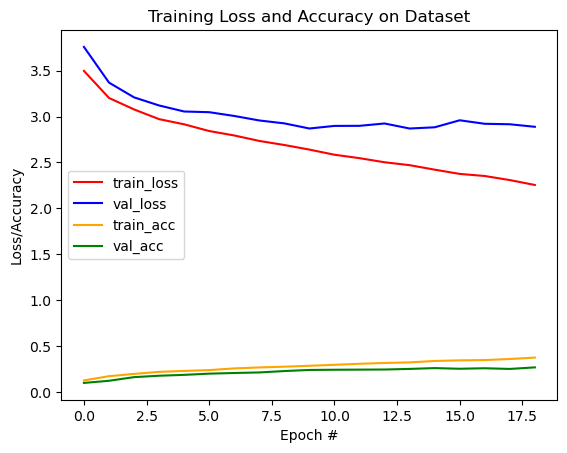

In [10]:
evaluate = food_model.evaluate(test_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [11]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [12]:
current_datetime = datetime.now()

# Save Model
food_model.save(f'food_model_{current_datetime}')

# Save .h5 model
food_model.save(f'food_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./food_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'food_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)